<a href="https://colab.research.google.com/github/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo update-alternatives --config python3

update-alternatives: error: no alternatives for python3


In [ ]:
# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

#install colab's dependencies
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
!ln -s /usr/local/lib/python3.9/dist-packages/google \
       /usr/local/lib/python3.8/dist-packages/google

# There has got to be a better way to do this...but there's a bad import in some of the colab files
# IPython no longer exposes traitlets like this, it's a separate package now
!sed -i "s/from IPython.utils import traitlets as _traitlets/import traitlets as _traitlets/" /usr/local/lib/python3.8/dist-packages/google/colab/*.py
!sed -i "s/from IPython.utils import traitlets/import traitlets/" /usr/local/lib/python3.8/dist-packages/google/colab/*.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2224k  100 2224k    0     0  17.4M      0 --:--:-- --:--:-- --:--:-- 17.5M
  Using cached pip-24.1.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.1.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.7 MB/s eta 0:00:00
ln: failed to create symbolic link '/usr/local/lib/python3.8/dist-packages/google': No such file or directory
sed: can't read /usr/local/lib/python3.8/dist-packages/google/colab/*.py: No such file or directory
sed: can't read /usr/local/lib/python3.8/dist-packages/google/colab/*.py: No such file or directory


In [ ]:
#check python version
import sys
print(sys.version)
!python3 --version
!python --version

3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
Python 3.10.12
Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GAN-BERT (in Pytorch and compatible with HuggingFace)

This is a Pytorch (+ **Huggingface** transformers) implementation of the GAN-BERT model from https://github.com/crux82/ganbert. While the original GAN-BERT was an extension of BERT, this implementation can be adapted to several architectures, ranging from Roberta to Albert!

**NOTE**: given that this implementation is different from the original one in Tensorflow, some results can be slighty different.


Let's GO!

Required Imports.

In [ ]:
!pip list | grep packaging

packaging                        24.1


In [ ]:
pip install packaging==21.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
!pip install transformers==4.3.2
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install sentencepiece
!pip install pandas

import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import pandas as pd
import pickle
import csv


##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Input Parameters


In [ ]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator,
# each of the size of the output space
num_hidden_layers_g = 1;
# number of hidden layers in the discriminator,
# each of the size of the input space
num_hidden_layers_d = 1;
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets,
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 10
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

#model_name = "bert-base-cased"
model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
#! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
labeled_file = "/content/ganbert/data/labeled.tsv"
unlabeled_file = "/content/ganbert/data/unlabeled.tsv"
test_filename = "/content/ganbert/data/test.tsv"
opspam = "./data/opspam.txt"                                            #Don't have
chicago_unlab = "./data/chicago_unlab.txt"                              #Don't Have
opspam_test = "./data/opspam_test.txt"                                  #Don't have
review_content = "/content/drive/MyDrive/Master_Project_2024_JP/yelpZip/YelpZip/reviewContent"
metadata = "/content/drive/MyDrive/Master_Project_2024_JP/yelpZip/YelpZip/metadata"
outlabsp = "/content/drive/MyDrive/Master_Project_2024_JP/CSC502 Thomas Project/Yelp_dataset_Sirish/outlabsp.txt"
outrevsp = "/content/drive/MyDrive/Master_Project_2024_JP/CSC502 Thomas Project/Yelp_dataset_Sirish/outrevsp.txt"
#review_content = "./Yelp/YelpNYC/reviewContent"
#metadata = "./Yelp/YelpNYC/metadata"





Load the Tranformer Model

In [ ]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/model.safetensors
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights 

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

Function required to load the dataset

In [ ]:
#label_list = get_labels(product_id_mapping)

label_list = ["1", "0"]
label_list.append('UNL')
label_list

['1', '0', 'UNL']

In [ ]:
with open('/content/drive/MyDrive/Master_Project_2024_JP/CSC502 Thomas Project/models/GANBERT/data/yelp_test_ns_400.pkl', 'rb') as f:
  test_examples = pickle.load(f)

with open('/content/drive/MyDrive/Master_Project_2024_JP/CSC502 Thomas Project/models/GANBERT/data/yelp_unlabeled_90_ns_400.pkl', 'rb') as f:
  unlabeled_examples = pickle.load(f)

with open('/content/drive/MyDrive/Master_Project_2024_JP/CSC502 Thomas Project/models/GANBERT/data/yelp_labeled_90_ns_400.pkl', 'rb') as f:
  labeled_examples = pickle.load(f)

In [ ]:
len(test_examples)

160

In [ ]:
test_examples[1]

("We chose to stay at the Hilton Chicago because it was in such a centralized location- everything that our family wanted to do in town was located so close! What I didn't expect was for the beds to be so comfortable. I can't remember when I got a better night's sleep. The staff was very friendly and the hotel grounds were impeccably kept. We'll be returning to the Hilton Chicago the next time we're in town!",
 '1')

In [ ]:
len(unlabeled_examples)

320

In [ ]:
len(labeled_examples)

320

In [ ]:
labeled_examples[1]

("The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! ",
 '0')

Functions required to convert examples into Dataloader

Convert the input examples into DataLoader

In [ ]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask:
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples):
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))

  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization -THIS NEEDS TO BE MODIFIED TO SKIP TOKENIZATION IF THE token
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)      #Set input_ids as none because we will be using Bert tokenizer for non-geo entities
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)

  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids)
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset),
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

<ipython-input-21-16c38d5f7491>:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


We define the Generator and Discriminator as discussed in https://www.aclweb.org/anthology/2020.acl-main.191/

In [ ]:
#------------------------------
#   The Generator as in
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

We instantiate the Discriminator and Generator

In [ ]:
# The config file is required to get the dimension of the vector produced by
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



Let's go with the training procedure

In [ ]:
for z in range(1, 3):
  label_map = {}
  for (i, label) in enumerate(label_list):
    label_map[label] = i
  #------------------------------
  #   Load the train dataset
  #------------------------------
  train_examples = labeled_examples
  #The labeled (train) dataset is assigned with a mask set to True
  train_label_masks = np.ones(len(labeled_examples), dtype=bool)
  #If unlabel examples are available
  if unlabeled_examples:
    train_examples = train_examples + unlabeled_examples
    #The unlabeled (train) dataset is assigned with a mask set to False
    tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
    train_label_masks = np.concatenate([train_label_masks,tmp_masks])

  train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

  #------------------------------
  #   Load the test dataset
  #------------------------------
  #The labeled (test) dataset is assigned with a mask set to True
  test_label_masks = np.ones(len(test_examples), dtype=bool)

  test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

  ###########################################################


  # The config file is required to get the dimension of the vector produced by
  # the underlying transformer
  config = AutoConfig.from_pretrained(model_name)
  hidden_size = int(config.hidden_size)
  # Define the number and width of hidden layers
  hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
  hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

  #-------------------------------------------------
  #   Instantiate the Generator and Discriminator
  #-------------------------------------------------
  generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
  discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

  # Put everything in the GPU if available
  if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    transformer.cuda()
    if multi_gpu:
      transformer = torch.nn.DataParallel(transformer)

  # print(config)


  ###########################################################



  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  #models parameters
  transformer_vars = [i for i in transformer.parameters()]
  d_vars = transformer_vars + [v for v in discriminator.parameters()]
  g_vars = [v for v in generator.parameters()]

  #optimizer
  dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
  gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator)

  #scheduler
  if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler_d = get_constant_schedule_with_warmup(dis_optimizer,
                                            num_warmup_steps = num_warmup_steps)
    scheduler_g = get_constant_schedule_with_warmup(gen_optimizer,
                                            num_warmup_steps = num_warmup_steps)

  # For each epoch...
  for epoch_i in range(0, num_train_epochs):
      # ========================================
      #               Training
      # ========================================
      # Perform one full pass over the training set.
      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      tr_g_loss = 0
      tr_d_loss = 0

      # Put the model into training mode.
      transformer.train()
      generator.train()
      discriminator.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every print_each_n_step batches.
          if step % print_each_n_step == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          b_label_mask = batch[3].to(device)

          real_batch_size = b_input_ids.shape[0]

          # Encode real data in the Transformer
          model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
          #model_outputs = transformer(input_ids = None, inputs_embeds = inputs_embeds, attention_mask=b_input_mask)                  #Verify this with Dr.Chen
          hidden_states = model_outputs[-1]

          # Generate fake data that should have the same distribution of the ones
          # encoded by the transformer.
          # First noisy input are used in input to the Generator
          noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
          # Gnerate Fake data
          gen_rep = generator(noise)

          # Generate the output of the Discriminator for real and fake data.
          # First, we put together the output of the tranformer and the generator
          disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
          # Then, we select the output of the disciminator
          features, logits, probs = discriminator(disciminator_input)

          # Finally, we separate the discriminator's output for the real and fake
          # data
          features_list = torch.split(features, real_batch_size)
          D_real_features = features_list[0]
          D_fake_features = features_list[1]

          logits_list = torch.split(logits, real_batch_size)
          D_real_logits = logits_list[0]
          D_fake_logits = logits_list[1]

          probs_list = torch.split(probs, real_batch_size)
          D_real_probs = probs_list[0]
          D_fake_probs = probs_list[1]

          #---------------------------------
          #  LOSS evaluation
          #---------------------------------
          # Generator's LOSS estimation
          g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
          g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
          g_loss = g_loss_d + g_feat_reg

          # Disciminator's LOSS estimation
          logits = D_real_logits[:,0:-1]
          log_probs = F.log_softmax(logits, dim=-1)
          # The discriminator provides an output for labeled and unlabeled real data
          # so the loss evaluated for unlabeled data is ignored (masked)
          label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
          per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
          per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
          labeled_example_count = per_example_loss.type(torch.float32).numel()

          # It may be the case that a batch does not contain labeled examples,
          # so the "supervised loss" in this case is not evaluated
          if labeled_example_count == 0:
            D_L_Supervised = 0
          else:
            D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

          D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
          D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
          d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

          #---------------------------------
          #  OPTIMIZATION
          #---------------------------------
          # Avoid gradient accumulation
          gen_optimizer.zero_grad()
          dis_optimizer.zero_grad()

          # Calculate weigth updates
          # retain_graph=True is required since the underlying graph will be deleted after backward
          g_loss.backward(retain_graph=True)
          d_loss.backward()

          # Apply modifications
          gen_optimizer.step()
          dis_optimizer.step()

          # A detail log of the individual losses
          #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
          #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
          #             g_loss_d, g_feat_reg))

          # Save the losses to print them later
          tr_g_loss += g_loss.item()
          tr_d_loss += d_loss.item()

          # Update the learning rate with the scheduler
          if apply_scheduler:
            scheduler_d.step()
            scheduler_g.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss_g = tr_g_loss / len(train_dataloader)
      avg_train_loss_d = tr_d_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
      print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
      print("  Training epcoh took: {:}".format(training_time))

      # ========================================
      #     TEST ON THE EVALUATION DATASET
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our test set.
      print("")
      print("Running Test...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      transformer.eval() #maybe redundant
      discriminator.eval()
      generator.eval()

      # Tracking variables
      total_test_accuracy = 0

      total_test_loss = 0
      nb_test_steps = 0

      all_preds = []
      all_labels_ids = []

      #loss
      nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

      # Evaluate data for one epoch
      for batch in test_dataloader:

          # Unpack this training batch from our dataloader.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():
              model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
              hidden_states = model_outputs[-1]
              _, logits, probs = discriminator(hidden_states)
              ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
              filtered_logits = logits[:,0:-1]
              # Accumulate the test loss.
              total_test_loss += nll_loss(filtered_logits, b_labels)

          # Accumulate the predictions and the input labels
          _, preds = torch.max(filtered_logits, 1)
          all_preds += preds.detach().cpu()
          all_labels_ids += b_labels.detach().cpu()

      # Report the final accuracy for this validation run.
      all_preds = torch.stack(all_preds).numpy()
      all_labels_ids = torch.stack(all_labels_ids).numpy()
      test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
      print("  Accuracy: {0:.3f}".format(test_accuracy))

      # Calculate the average loss over all of the batches.
      avg_test_loss = total_test_loss / len(test_dataloader)
      avg_test_loss = avg_test_loss.item()

      # Measure how long the validation run took.
      test_time = format_time(time.time() - t0)

      print("  Test Loss: {0:.3f}".format(avg_test_loss))
      print("  Test took: {:}".format(test_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss generator': avg_train_loss_g,
              'Training Loss discriminator': avg_train_loss_d,
              'Valid. Loss': avg_test_loss,
              'Valid. Accur.': test_accuracy,
              'Training Time': training_time,
              'Test Time': test_time,
              'Preds': all_preds,
              'Labels': all_labels_ids
          }
      )

  last_pred = []
  last_label = []
  for stat in training_stats:
    last_pred = stat['Preds']
    last_label = stat['Labels']


  print("\nTraining complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  with open('/content/drive/MyDrive/Master_Project_2024_JP/CSC502 Thomas Project/models/GANBERT/runs/'+ str(z) +'/training_stats_lab_yelp_100L_ns_400R.pkl', 'wb') as f:
    pickle.dump(training_stats, f)

<ipython-input-21-16c38d5f7491>:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vo


======== Epoch 1 / 10 ========
Training...

  Average training loss generetor: 0.371
  Average training loss discriminator: 1.887
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.681
  Test Loss: 1.133
  Test took: 0:00:00

======== Epoch 2 / 10 ========
Training...

  Average training loss generetor: 0.548
  Average training loss discriminator: 1.065
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.550
  Test Loss: 1.849
  Test took: 0:00:00

======== Epoch 3 / 10 ========
Training...

  Average training loss generetor: 0.776
  Average training loss discriminator: 0.724
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.512
  Test Loss: 2.449
  Test took: 0:00:01

======== Epoch 4 / 10 ========
Training...

  Average training loss generetor: 0.837
  Average training loss discriminator: 0.656
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.562
  Test Loss: 2.314
  Test took: 0:00:01

======== Epoch 5 / 10 ========
Training...

  Avera

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}




======== Epoch 1 / 10 ========
Training...

  Average training loss generetor: 0.361
  Average training loss discriminator: 1.992
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.531
  Test Loss: 1.476
  Test took: 0:00:01

======== Epoch 2 / 10 ========
Training...

  Average training loss generetor: 0.535
  Average training loss discriminator: 1.100
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.569
  Test Loss: 1.879
  Test took: 0:00:01

======== Epoch 3 / 10 ========
Training...

  Average training loss generetor: 0.758
  Average training loss discriminator: 0.746
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.550
  Test Loss: 2.150
  Test took: 0:00:01

======== Epoch 4 / 10 ========
Training...

  Average training loss generetor: 0.845
  Average training loss discriminator: 0.648
  Training epcoh took: 0:00:10

Running Test...
  Accuracy: 0.581
  Test Loss: 2.390
  Test took: 0:00:01

======== Epoch 5 / 10 ========
Training...

  Avera

In [ ]:
last_pred = []
last_label = []
for stat in training_stats:
  last_pred = stat['Preds']
  last_label = stat['Labels']


print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Training complete!
Total training took 0:03:46 (h:mm:ss)


In [ ]:
with open('/content/drive/MyDrive/Master_Project_2024_JP/CSC502 Thomas Project/models/GANBERT/runs/1/training_stats_lab_ns_100.pkl', 'wb') as f:
  pickle.dump(training_stats, f)

In [ ]:
last_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
last_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

In [ ]:
for z in range(1, 2):
  with open('/content/drive/MyDrive/CSC 502/GAN-BERT/runs/'+ str(z) +'/training_stats_lab_op_spam_100_s.pkl', 'rb') as f:
    print(z)
    training_stats = pickle.load(f)

  last_pred = []
  last_label = []
  for stat in training_stats:
    last_pred = stat['Preds']
    last_label = stat['Labels']

  target_names = ['real', 'fake']
  print(classification_report(last_label, last_pred, target_names=target_names))

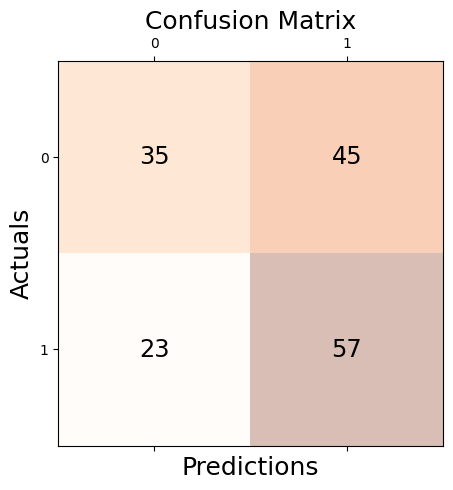

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
#
# Standardize the data set
#

#
# Fit the SVC model
#

#
# Get the predictions
#

#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=last_label, y_pred=last_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

target_names = ['non-spam', 'spam']
print(classification_report(last_label, last_pred, target_names=target_names))

              precision    recall  f1-score   support

    non-spam       0.60      0.44      0.51        80
        spam       0.56      0.71      0.63        80

    accuracy                           0.57       160
   macro avg       0.58      0.57      0.57       160
weighted avg       0.58      0.57      0.57       160



In [ ]:
rN